In [1]:
import pandas as pd

import numpy as np
import basedosdados as bd
from pywaffle import Waffle
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from textwrap import wrap
import contextily as ctx

from shapely.wkt import loads
import geopandas as gpd

from datetime import date


chamado_1746 = pd.read_parquet("../data/chamado_1746.parquet")
bairro = pd.read_parquet("../data/bairro.parquet")
ocupacao_eventos = pd.read_parquet("../data/rede_hoteleira_ocupacao_eventos.parquet")

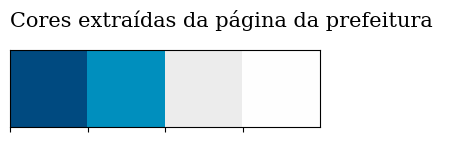

In [2]:
# Palette
sns.palplot(["#004A80", "#008FBE", "#ECECEC", "#FEFEFE"])

plt.title(
    "Cores extraídas da página da prefeitura ",
    loc="left",
    fontfamily="serif",
    fontsize=15,
    y=1.2,
)
plt.show()

## Localização de chamados do 1746

Gráficos gerados para as perguntas referentes ao chamado 1746 no dia 01/04/2023

In [3]:
number_of_calls = chamado_1746.loc[
    chamado_1746["data_inicio"].dt.date == date(2023, 4, 1)
].shape[0]


number_of_calls_by_type = chamado_1746.loc[
    chamado_1746["data_inicio"].dt.date == date(2023, 4, 1)
]["tipo"].value_counts()


number_of_calls_by_type[
    "; ".join(number_of_calls_by_type.loc[lambda x: x < 2].index)
] = number_of_calls_by_type.loc[number_of_calls_by_type < 2].sum()

number_of_calls_by_type = number_of_calls_by_type.loc[lambda x: x >= 2]

In [4]:
color_map = ["#ECECEC" for _ in range(number_of_calls_by_type.shape[0] + 1)]
color_map[0] = "#004A80"

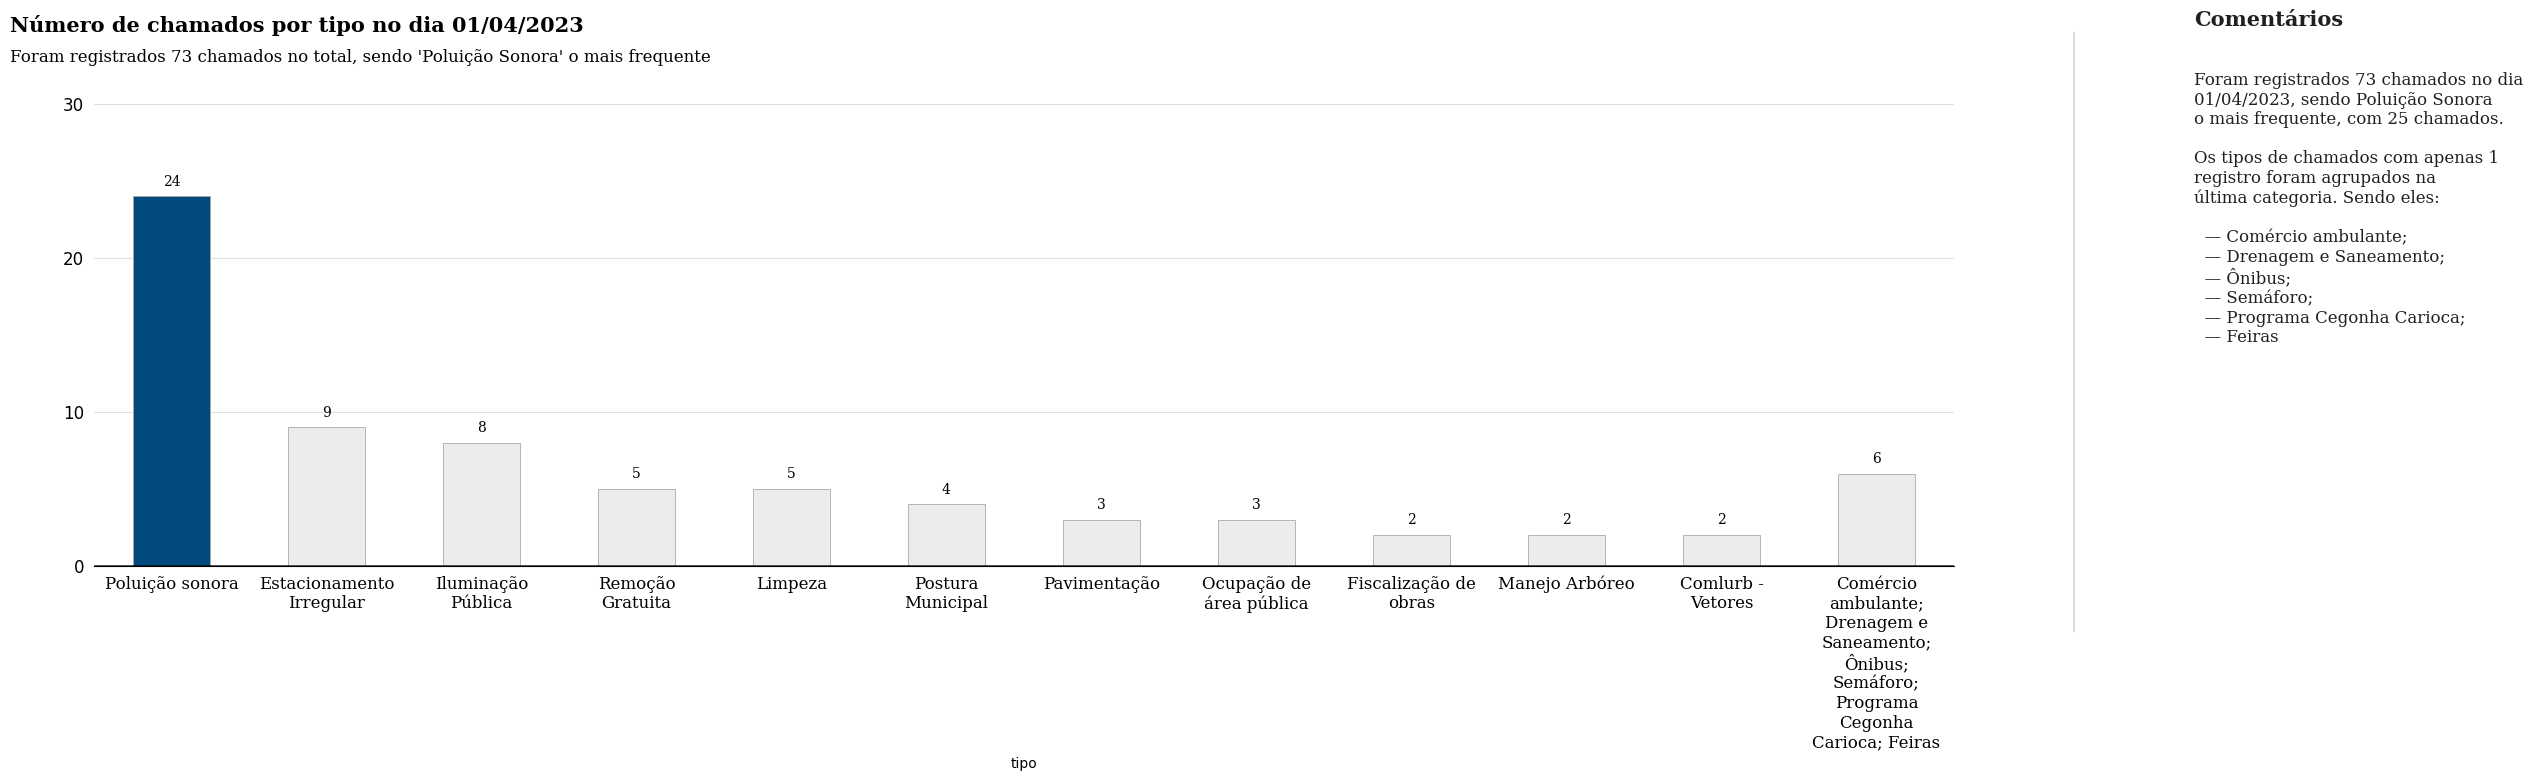

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(24, 6))
(
    number_of_calls_by_type.plot(
        kind="bar",
        color=color_map,
        ax=ax,
        edgecolor="darkgray",
        width=0.5,
        linewidth=0.6,
    )
)

# Anotações
for i, v in enumerate(number_of_calls_by_type):
    ax.text(
        i,
        v + 0.5,
        str(v),
        ha="center",
        va="bottom",
        fontweight="light",
        fontfamily="serif",
    )


# Remove spines
# for spine in ax.spines:
for spine in ["top", "left", "right"]:
    ax.spines[spine].set_visible(False)


# Ticks
ax.set_xticklabels(
    ["\n".join(wrap(l, 15)) for l in number_of_calls_by_type.index],
    rotation=0,
    fontfamily="serif",
)

# Título e subtítulo
fig.text(
    0.09,
    1,
    "Número de chamados por tipo no dia 01/04/2023",
    fontsize=15,
    color="black",
    weight="bold",
    fontfamily="serif",
)

fig.text(
    0.09,
    0.95,
    f"Foram registrados {number_of_calls} chamados no total, sendo 'Poluição Sonora' o mais frequente",
    fontsize=12,
    color="black",
    fontfamily="serif",
    weight="light",
)


fig.text(
    1,
    1.01,
    "Comentários",
    fontsize=15,
    weight="bold",
    fontfamily="serif",
    color="#221f1f",
)

fig.text(
    1,
    0.45,
    """
Foram registrados 73 chamados no dia
01/04/2023, sendo Poluição Sonora
o mais frequente, com 25 chamados.

Os tipos de chamados com apenas 1
registro foram agrupados na 
última categoria. Sendo eles:

  — Comércio ambulante; 
  — Drenagem e Saneamento; 
  — Ônibus; 
  — Semáforo; 
  — Programa Cegonha Carioca; 
  — Feiras 
""",
    fontsize=12,
    weight="light",
    fontfamily="serif",
    color="#221f1f",
)

ax.grid(axis="y", linestyle="-", alpha=0.4)

grid_y_ticks = np.arange(0, 40, 10)  # y ticks, min, max, then step
ax.set_yticks(grid_y_ticks)
ax.set_axisbelow(True)


plt.axhline(y=0, color="black", linewidth=1.3, alpha=0.7)
ax.tick_params(axis="both", which="major", labelsize=12)


l1 = lines.Line2D(
    [0.95, 0.95], [0, 1], transform=fig.transFigure, figure=fig, color="black", lw=0.2
)
fig.lines.extend([l1])

ax.tick_params(axis="both", which="both", bottom=False, left=False)

plt.show()

In [6]:
neighboards_by_calls = (
    chamado_1746.loc[
        chamado_1746["data_inicio"].dt.date == date(2023, 4, 1), ["id_bairro"]
    ]
    .merge(bairro, left_on="id_bairro", right_on="id_bairro")
    .groupby("id_bairro")
    .agg(
        {
            "id_bairro": "count",
            "nome": "first",
            "subprefeitura": "first",
            "geometry": "first",
        }
    )
    .rename(columns={"id_bairro": "chamados"})
    .sort_values("chamados", ascending=False)
)


gdf = gpd.GeoDataFrame(
    neighboards_by_calls,
    geometry=neighboards_by_calls["geometry"].apply(loads),
    crs="EPSG:4326",
)

# 4. Qual o nome da subprefeitura com mais chamados abertos nesse dia?

region_with_most_calls = (
    neighboards_by_calls.groupby("subprefeitura")
    .agg({"chamados": "sum"})
    .idxmax()
    .values[0]
)

region_with_most_calls

'Zona Norte'

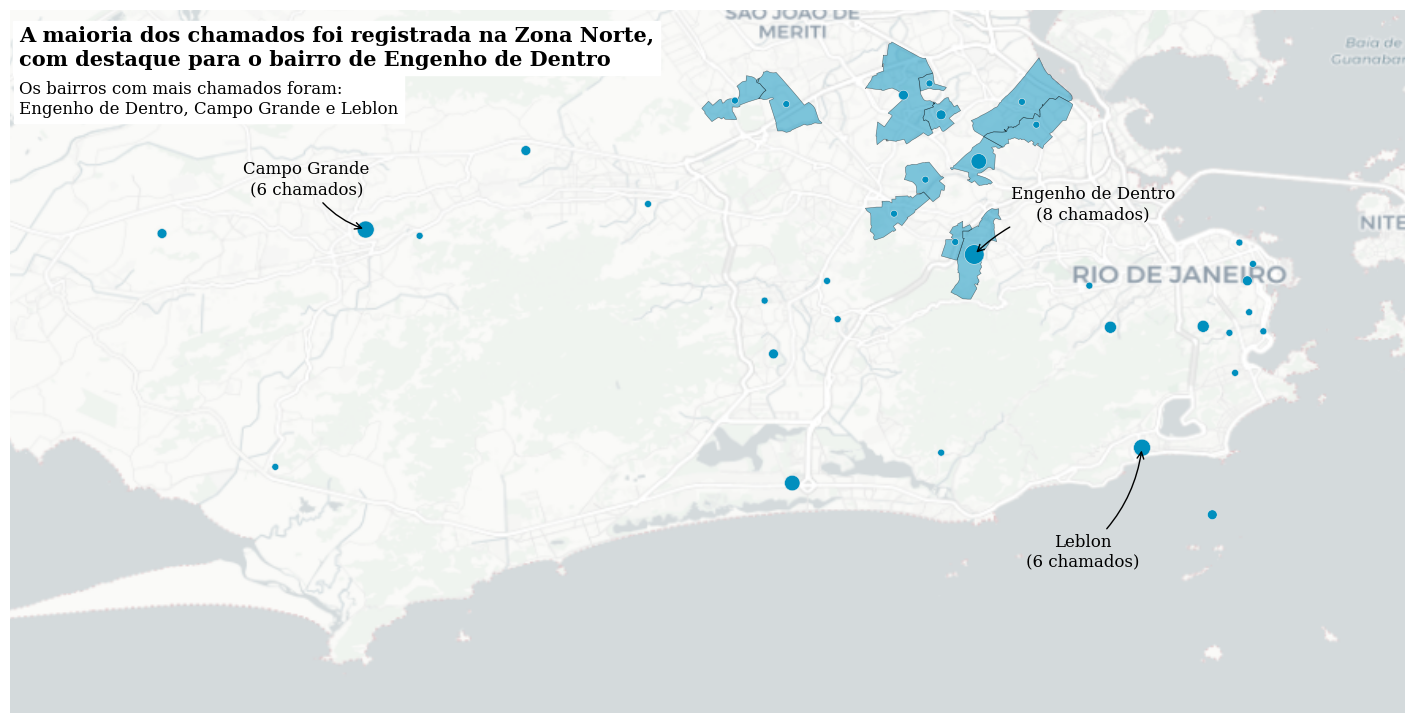

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(18, 16))
gdf.plot(ax=ax, edgecolor="black", linewidth=0.4, alpha=0)
gdf.loc[gdf["subprefeitura"] == region_with_most_calls].plot(
    ax=ax, color="#008FBE", edgecolor="black", linewidth=0.4, alpha=0.5
)


ax.scatter(
    x=gdf.centroid.x,
    y=gdf.centroid.y,
    s=gdf["chamados"] * 25,
    color="#008FBE",
    edgecolor="#ECECEC",
    linewidth=0.4,
)

# remove spines
for spine in ax.spines:
    ax.spines[spine].set_visible(False)

# remove x and y ticks
ax.tick_params(
    axis="both",
    which="both",
    bottom=False,
    left=False,
    labelbottom=False,
    labelleft=False,
)

# Anotar o bairro com mais chamados
ax.annotate(
    f"{gdf['nome'].iloc[0]}\n({gdf['chamados'].iloc[0]} chamados)",
    xy=(gdf["geometry"].centroid.x.iloc[0], gdf["geometry"].centroid.y.iloc[0]),
    xytext=(
        gdf["geometry"].centroid.x.iloc[0] + 0.05,
        gdf["geometry"].centroid.y.iloc[0] + 0.015,
    ),
    ha="center",
    fontfamily="serif",
    fontsize=12,
    fontweight="light",
    arrowprops=dict(facecolor="black", arrowstyle="->", connectionstyle="arc3,rad=0.2"),
)

# anotar o segundo bairro com mais chamados
ax.annotate(
    f"{gdf['nome'].iloc[1]}\n({gdf['chamados'].iloc[1]} chamados)",
    xy=(gdf["geometry"].centroid.x.iloc[1], gdf["geometry"].centroid.y.iloc[1]),
    xytext=(
        gdf["geometry"].centroid.x.iloc[1] - 0.025,
        gdf["geometry"].centroid.y.iloc[1] + 0.015,
    ),
    ha="center",
    fontfamily="serif",
    fontsize=12,
    fontweight="light",
    arrowprops=dict(facecolor="black", arrowstyle="->", connectionstyle="arc3,rad=0.2"),
)

# anotar o terceiro bairro com mais chamados
ax.annotate(
    f"{gdf['nome'].iloc[2]}\n({gdf['chamados'].iloc[2]} chamados)",
    xy=(gdf["geometry"].centroid.x.iloc[2], gdf["geometry"].centroid.y.iloc[2]),
    xytext=(
        gdf["geometry"].centroid.x.iloc[2] - 0.025,
        gdf["geometry"].centroid.y.iloc[2] - 0.05,
    ),
    ha="center",
    fontfamily="serif",
    fontsize=12,
    fontweight="light",
    arrowprops=dict(facecolor="black", arrowstyle="->", connectionstyle="arc3,rad=0.2"),
)

# título
fig.text(
    0.13,
    0.68,
    "A maioria dos chamados foi registrada na Zona Norte,\ncom destaque para o bairro de Engenho de Dentro",
    fontsize=15,
    color="black",
    weight="bold",
    fontfamily="serif",
    backgroundcolor="white",
)

# subtítulo
fig.text(
    0.13,
    0.65,
    f"Os bairros com mais chamados foram:\n{gdf['nome'].iloc[0]}, {gdf['nome'].iloc[1]} e {gdf['nome'].iloc[2]}",
    fontsize=12,
    color="black",
    fontfamily="serif",
    weight="light",
    backgroundcolor="white",
)


ctx.add_basemap(
    ax, source=ctx.providers.CartoDB.Positron, attribution=False, crs="EPSG:4326"
)

plt.show()

## Chamados do 1746 em grandes eventos

In [8]:
def get_event(date):
    event = ocupacao_eventos.loc[
        (date >= ocupacao_eventos["data_inicial"])
        & (date <= ocupacao_eventos["data_final"]),
        "evento",
    ]
    return event.item() if event.shape[0] > 0 else None


chamado_pertubacao_sossego = (
    chamado_1746.loc[
        chamado_1746["data_inicio"].dt.year.between(2022, 2023)
        & (chamado_1746["subtipo"] == "Perturbação do sossego")
    ]
    .assign(durante_evento=lambda d: d["data_inicio"].dt.date.apply(get_event))
    .merge(ocupacao_eventos, left_on="durante_evento", right_on="evento", how="left")
    .drop_duplicates("id_chamado")
)
chamado_pertubacao_sossego["data"] = chamado_pertubacao_sossego["data_inicio"].dt.date

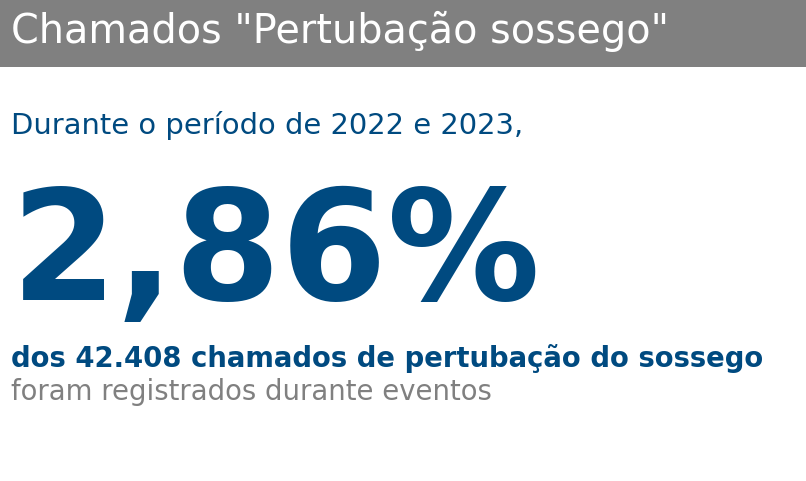

In [9]:
events_percentage = (
    chamado_pertubacao_sossego["durante_evento"]
    .value_counts(normalize=True, dropna=False)
    .reset_index()
    .loc[lambda x: x["durante_evento"].notna(), "proportion"]
    .sum()
)

plt.figure(figsize=(7.45, 4.9), dpi=110)

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.tick_params(
    top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False
)

plt.text(
    -0.15,
    1.03,
    'Chamados "Pertubação sossego"' + " " * 10,
    fontsize=26,
    color="white",
    bbox={"facecolor": "gray", "pad": 10, "edgecolor": "none"},
)

plt.text(
    -0.15,
    0.81,
    "Durante o período de 2022 e 2023,",
    fontsize=19,
    color="#004A80",
)

plt.text(
    -0.15,
    0.41,
    f"{events_percentage:.2%}".replace(".", ","),
    fontsize=100,
    color="#004A80",
    weight="bold",
)
plt.text(
    -0.15,
    0.25,
    f"dos {chamado_pertubacao_sossego.shape[0]:,} chamados de pertubação do sossego".replace(
        ",", "."
    ),
    fontsize=18,
    color="#004A80",
    weight="bold",
)

plt.text(
    -0.15,
    0.17,
    "foram registrados durante eventos",
    fontsize=18,
    color="gray",
)

plt.show()

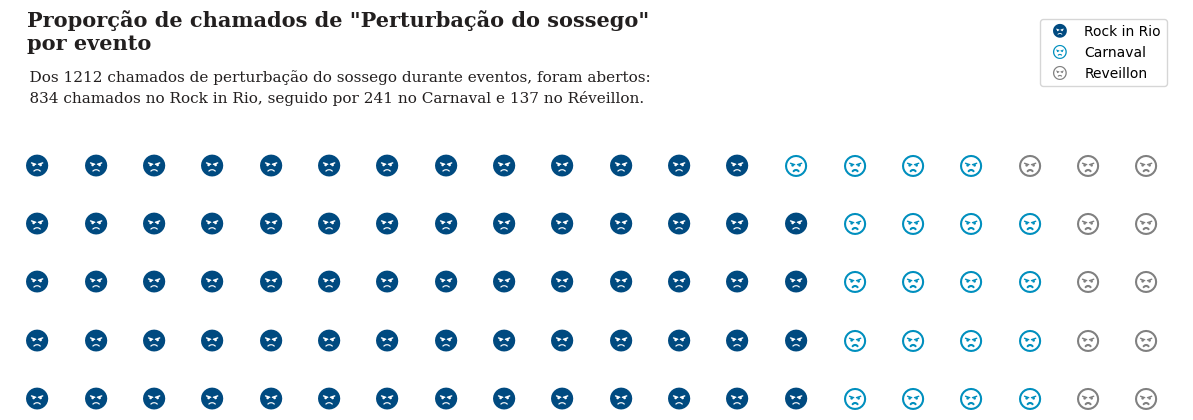

In [10]:
chamados_totais = (
    chamado_pertubacao_sossego["durante_evento"]
    .value_counts(normalize=True)
    .reset_index()
    .rename(columns={"durante_evento": "evento", "proportion": "chamados"})
    .fillna("Sem evento")
    .assign(chamados=lambda d: d["chamados"] * 100)
)

fig = plt.figure(
    FigureClass=Waffle,
    rows=5,
    values=chamados_totais["chamados"],
    labels=list(chamados_totais["evento"]),
    figsize=(12, 12),
    legend={"loc": "upper left", "bbox_to_anchor": (0.87, 1.4)},
    colors=["#004A80", "#008FBE", "gray"],
    icons="face-angry",
    font_size=16,
    icon_legend=True,
    icon_style=["solid", "regular", "regular"],
)

fig.text(
    0.013,
    0.68,
    'Proporção de chamados de "Perturbação do sossego"\npor evento',
    fontsize=15,
    weight="bold",
    fontfamily="serif",
    color="#221f1f",
)

fig.text(
    -0.001,
    0.62,
    """
    Dos 1212 chamados de perturbação do sossego durante eventos, foram abertos:
    834 chamados no Rock in Rio, seguido por 241 no Carnaval e 137 no Réveillon. 
    """,
    fontsize=11,
    weight="light",
    fontfamily="serif",
    color="#221f1f",
    linespacing=1.5,
)

fig.set_facecolor("white")

plt.show()

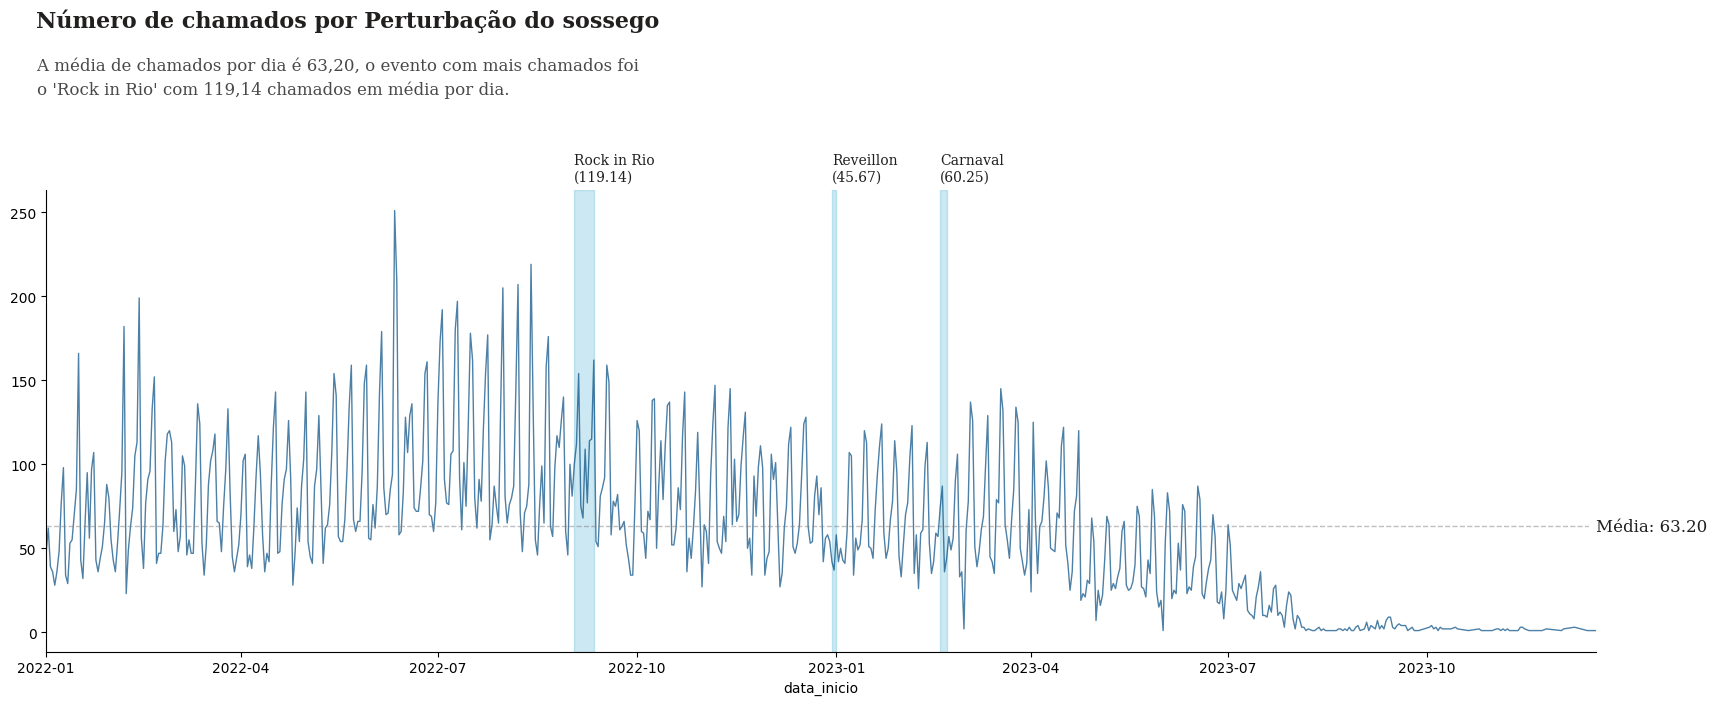

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))

chamado_pertubacao_sossego["data_inicio"].dt.date.value_counts().sort_index().plot(
    ax=ax, color="#004A80", linewidth=1, alpha=0.7
)


ax.set_xlim(
    chamado_pertubacao_sossego["data_inicio"].dt.date.min(),
    chamado_pertubacao_sossego["data_inicio"].dt.date.max(),
)


eventos_media = (
    chamado_pertubacao_sossego.groupby(["durante_evento", "data"])
    .size()
    .reset_index(name="count")
    .groupby("durante_evento")["count"]
    .mean()
    .sort_values(ascending=False)
    .to_frame(name="media")
)

# destacar os dias com eventos
eventos = (
    ocupacao_eventos.assign(
        mes=lambda d: pd.to_datetime(d["data_inicial"]).dt.month,
        ano=lambda d: pd.to_datetime(d["data_inicial"]).dt.year,
    )
    .groupby(["mes", "ano", "evento"])
    .agg({"data_inicial": "min", "data_final": "max"})
    .reset_index()
)


for i, row in eventos.iterrows():
    ax.axvspan(
        row["data_inicial"],
        row["data_final"],
        color="#008FBE",
        alpha=0.2,
        label=row["evento"],
    )
    ax.text(
        row["data_inicial"],
        chamado_pertubacao_sossego["data_inicio"].dt.date.value_counts().max() + 25,
        f"{row['evento']}\n({eventos_media.loc[row['evento']]['media']:0.2f})",
        ha="left",
        va="center",
        fontsize=10,
        fontfamily="serif",
        color="#221f1f",
    )


# Média de chamados por dia
ax.axhline(
    chamado_pertubacao_sossego["data_inicio"].dt.date.value_counts().mean(),
    color="gray",
    linewidth=1,
    alpha=0.5,
    linestyle="--",
)

ax.text(
    chamado_pertubacao_sossego["data_inicio"].dt.date.max(),
    chamado_pertubacao_sossego["data_inicio"].dt.date.value_counts().mean(),
    f"Média: {chamado_pertubacao_sossego['data_inicio'].dt.date.value_counts().mean():.2f}",
    ha="left",
    va="center",
    backgroundcolor="white",
    fontsize=12,
    fontfamily="serif",
    color="#221f1f",
)


for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)


fig.text(
    0.12,
    1.15,
    "Número de chamados por Perturbação do sossego",
    fontsize=16,
    color="#221f1f",
    weight="bold",
    fontfamily="serif",
)

fig.text(
    0.11,
    1,
    """
    A média de chamados por dia é 63,20, o evento com mais chamados foi 
    o 'Rock in Rio' com 119,14 chamados em média por dia.
    """,
    fontsize=12,
    color="#4a4949",
    fontfamily="serif",
    weight="light",
    linespacing=1.5,
)


plt.show()